In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
df = pd.read_csv("C:/Users/Shreya/Downloads/EDA1/EDA1/Cardiotocographic.csv")

In [15]:
#Handling missing values
print("Original Data Info:")
print(df.info())
print("\nMissing values before handling:")
print(df.isnull().sum())

Original Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   LB        2105 non-null   float64
 1   AC        2106 non-null   float64
 2   FM        2126 non-null   float64
 3   UC        2126 non-null   float64
 4   DL        2126 non-null   float64
 5   DS        2105 non-null   float64
 6   DP        2105 non-null   float64
 7   ASTV      2126 non-null   float64
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   float64
 10  MLTV      2105 non-null   float64
 11  Width     2105 non-null   float64
 12  Tendency  2105 non-null   float64
 13  NSP       2105 non-null   float64
dtypes: float64(14)
memory usage: 232.7 KB
None

Missing values before handling:
LB          21
AC          20
FM           0
UC           0
DL           0
DS          21
DP          21
ASTV         0
MSTV         0
ALTV         0
MLTV        21
Wid

In [17]:
# Drop rows where all values are NaN
df.dropna(how='all', inplace=True)

# Impute numerical columns with the median
for col in df.columns:
    # First, ensure column can be treated numerically. Coerce errors will turn invalid parsing into NaN.
    df[col] = pd.to_numeric(df[col], errors='coerce')
    if df[col].isnull().any() and df[col].dtype in ['float64', 'int64']:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

print("\nMissing values after initial handling:")
print(df.isnull().sum())
print("\nData types after initial conversion and imputation:")
print(df.dtypes)


Missing values after initial handling:
LB          0
AC          0
FM          0
UC          0
DL          0
DS          0
DP          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
Width       0
Tendency    0
NSP         0
dtype: int64

Data types after initial conversion and imputation:
LB          float64
AC          float64
FM          float64
UC          float64
DL          float64
DS          float64
DP          float64
ASTV        float64
MSTV        float64
ALTV        float64
MLTV        float64
Width       float64
Tendency    float64
NSP         float64
dtype: object


C:\Users\Shreya\AppData\Local\Temp\ipykernel_4192\2450200804.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


In [19]:
# 2. Identify and correct any inconsistencies in data types
# It's important to round them before converting to int, as they might have been floats due to imputation.
df['Tendency'] = df['Tendency'].round().astype(int)
df['NSP'] = df['NSP'].round().astype(int)

print("\nFinal data types after specific conversions:")
print(df.dtypes)


Final data types after specific conversions:
LB          float64
AC          float64
FM          float64
UC          float64
DL          float64
DS          float64
DP          float64
ASTV        float64
MSTV        float64
ALTV        float64
MLTV        float64
Width       float64
Tendency      int32
NSP           int32
dtype: object


In [21]:
# 3. Detect and treat outliers
# Correcting negative values that are logically impossible (e.g., percentages, counts, widths)
non_negative_cols = ['AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'LB']
for col in non_negative_cols:
    if df[col].min() < 0:
        print(f"Column {col} has negative values. Capping at 0.")
        df[col] = df[col].apply(lambda x: max(x, 0))

# For ASTV and ALTV, they are percentages, so cap at 100 as well.
for col in ['ASTV', 'ALTV']:
    if df[col].max() > 100:
        print(f"Column {col} has values > 100. Capping at 100.")
        df[col] = df[col].apply(lambda x: min(x, 100))

# Outlier treatment using IQR for other columns (numerical and not percentage-based)
outlier_cols = ['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'MSTV', 'MLTV', 'Width']

print("\nOutlier detection and treatment using IQR (capping):")
for col in outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers before capping
    outliers_before = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]

    # Capping outliers
    # Using .loc for direct assignment to avoid SettingWithCopyWarning
    df.loc[df[col] < lower_bound, col] = lower_bound
    df.loc[df[col] > upper_bound, col] = upper_bound

    # Count outliers after capping (should be 0 for IQR-capped values)
    outliers_after = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]

    if outliers_before > 0:
        print(f"  - Column '{col}': {outliers_before} outliers detected and capped.")
        # Re-check and confirm, though after capping, this should ideally be 0 if the capping strategy is strict.
        # However, new bounds due to capping itself could theoretically cause new outliers if you iterate,
        # but for a single pass of IQR capping, this is generally how it works.
        if outliers_after > 0:
            print(f"    Warning: {outliers_after} outliers still exist after capping. This might indicate extreme distributions or that the IQR method with fixed bounds is not fully removing all 'outliers' based on its definition after capping.")
    else:
        print(f"  - Column '{col}': No outliers detected for capping.")


print("\nFirst 5 rows of the cleaned and prepared DataFrame:")
print(df.head())
print("\nDescriptive statistics after cleaning:")
print(df.describe())
print("\nFinal data types after cleaning:")
print(df.dtypes)

Column AC has negative values. Capping at 0.
Column FM has negative values. Capping at 0.
Column UC has negative values. Capping at 0.
Column DL has negative values. Capping at 0.
Column DS has negative values. Capping at 0.
Column DP has negative values. Capping at 0.
Column ASTV has negative values. Capping at 0.
Column MSTV has negative values. Capping at 0.
Column ALTV has negative values. Capping at 0.
Column MLTV has negative values. Capping at 0.
Column Width has negative values. Capping at 0.
Column ASTV has values > 100. Capping at 100.
Column ALTV has values > 100. Capping at 100.

Outlier detection and treatment using IQR (capping):
  - Column 'LB': 10 outliers detected and capped.
  - Column 'AC': 39 outliers detected and capped.
  - Column 'FM': 340 outliers detected and capped.
  - Column 'UC': 9 outliers detected and capped.
  - Column 'DL': 119 outliers detected and capped.
  - Column 'DS': 67 outliers detected and capped.
  - Column 'DP': 232 outliers detected and capp

In [25]:
# --- Statistical Summary ---
# Select only numerical columns for the summary
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
summary_df = pd.DataFrame()

for col in numerical_cols:
    summary_df[col] = [
        df[col].mean(),
        df[col].median(),
        df[col].std(),
        df[col].quantile(0.25),
        df[col].quantile(0.75),
        df[col].quantile(0.75) - df[col].quantile(0.25)
    ]

summary_df.index = ['Mean', 'Median', 'Standard Deviation', 'Q1 (25th Percentile)', 'Q3 (75th Percentile)', 'IQR']

print("Statistical Summary of the Cleaned Dataset:")
print(summary_df.transpose())

Statistical Summary of the Cleaned Dataset:
             Mean      Median  Standard Deviation  Q1 (25th Percentile)  \
LB     133.290331  133.000000            9.930268            126.000000   
AC       0.003149    0.001634            0.003797              0.000000   
FM       0.001602    0.000000            0.002446              0.000000   
UC       0.004372    0.004484            0.002978              0.001851   
DL       0.001785    0.000000            0.002646              0.000000   
DS       0.000000    0.000000            0.000000              0.000000   
DP       0.000000    0.000000            0.000000              0.000000   
ASTV    46.998336   49.000000           17.498126             32.000000   
MSTV     1.305773    1.200000            0.778622              0.700000   
ALTV    10.150709    0.000000           19.095004              0.000000   
MLTV     8.018936    7.400000            5.023657              4.600000   
Width   70.422433   67.000000           39.231698       

In [27]:
# --- Highlight Interesting Findings ---
interesting_findings = []

# Check for significant differences between mean and median (skewness)
for col in numerical_cols:
    mean_val = df[col].mean()
    median_val = df[col].median()
    if mean_val != 0 and abs(mean_val - median_val) / mean_val > 0.1:
        interesting_findings.append(f"• The mean ({mean_val:.2f}) and median ({median_val:.2f}) for **{col}** are significantly different, suggesting a skewed distribution.")

# Check for high variability (large standard deviation relative to mean)
for col in numerical_cols:
    mean_val = df[col].mean()
    std_val = df[col].std()
    if mean_val > 0 and (std_val / mean_val) > 0.5:
        interesting_findings.append(f"• **{col}** has a high standard deviation ({std_val:.2f}) relative to its mean ({mean_val:.2f}), indicating high variability.")

# Check for min/max values after cleaning that might still be notable
if df['Width'].min() < 10:
    interesting_findings.append(f"• The minimum value for **Width** is very low ({df['Width'].min():.2f}), indicating a very narrow signal width in some instances.")
if df['MLTV'].max() > 40:
    interesting_findings.append(f"• The maximum value for **MLTV** is high ({df['MLTV'].max():.2f}), suggesting some signals have very long-term variability.")

print("\n--- Interesting Findings ---")
if interesting_findings:
    for finding in interesting_findings:
        print(finding)
else:
    print("No particularly interesting findings were detected based on the checks.")


--- Interesting Findings ---
• The mean (0.00) and median (0.00) for **AC** are significantly different, suggesting a skewed distribution.
• The mean (0.00) and median (0.00) for **FM** are significantly different, suggesting a skewed distribution.
• The mean (0.00) and median (0.00) for **DL** are significantly different, suggesting a skewed distribution.
• The mean (10.15) and median (0.00) for **ALTV** are significantly different, suggesting a skewed distribution.
• **AC** has a high standard deviation (0.00) relative to its mean (0.00), indicating high variability.
• **FM** has a high standard deviation (0.00) relative to its mean (0.00), indicating high variability.
• **UC** has a high standard deviation (0.00) relative to its mean (0.00), indicating high variability.
• **DL** has a high standard deviation (0.00) relative to its mean (0.00), indicating high variability.
• **MSTV** has a high standard deviation (0.78) relative to its mean (1.31), indicating high variability.
• **A

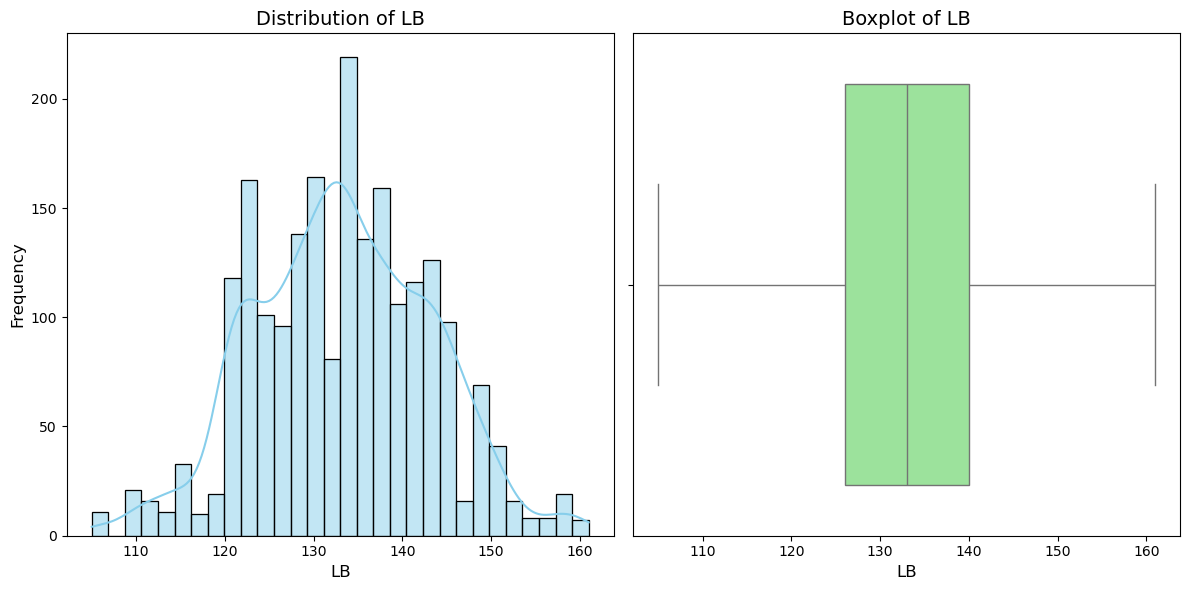

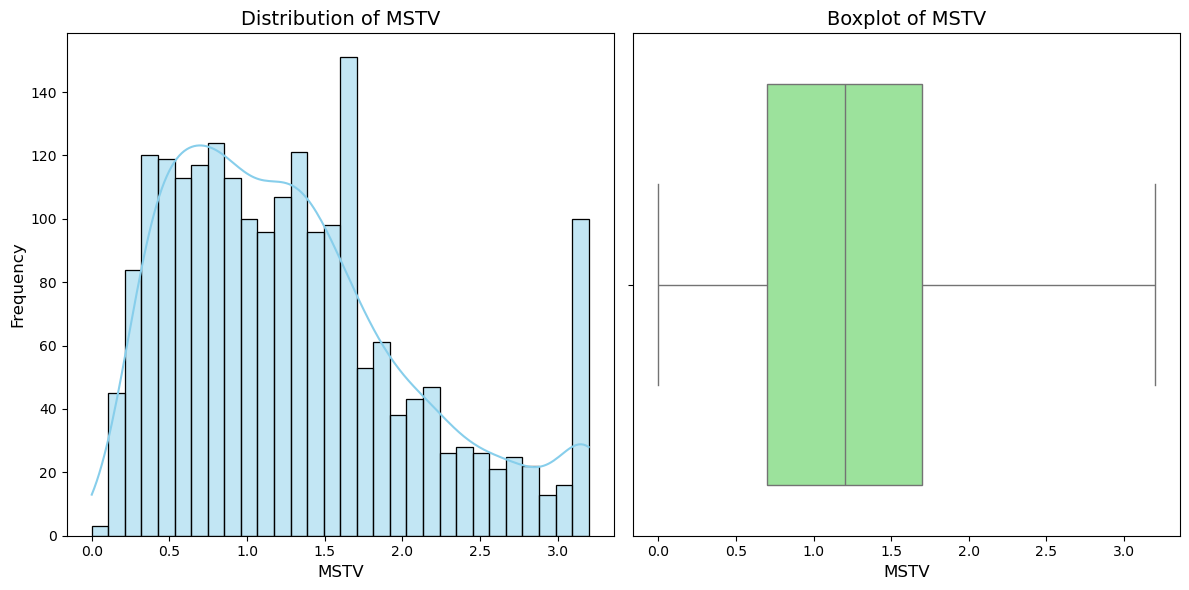

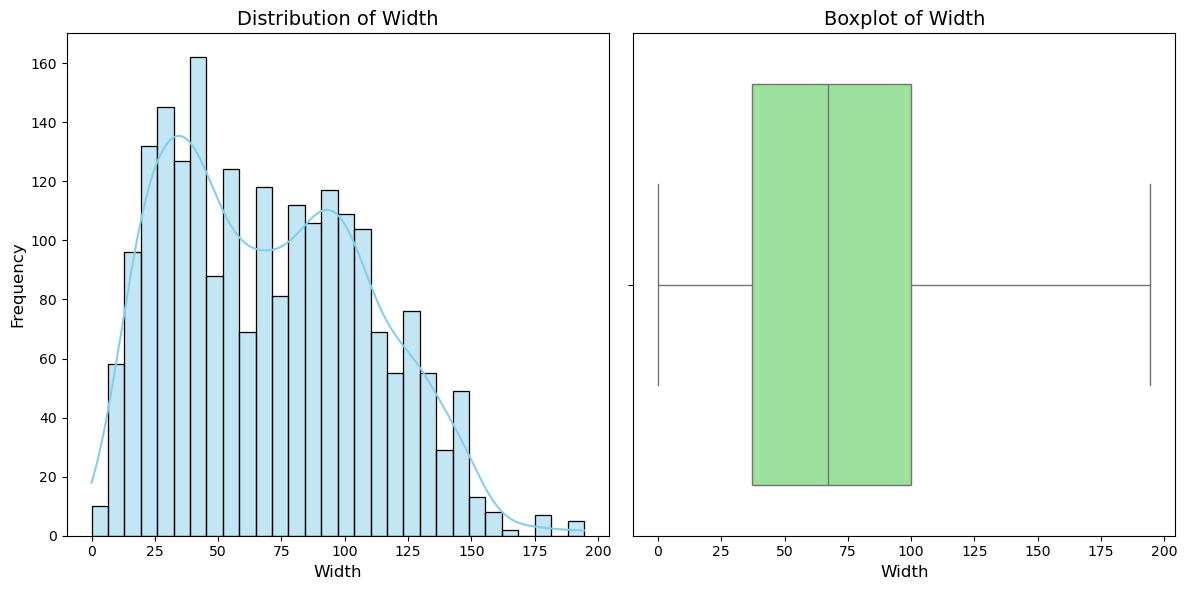

In [38]:
#---Data Visualisation-----(using matplotlib and seaborn)
# 1. Histograms and Boxplots for numerical variables
numerical_vars = ['LB', 'MSTV', 'Width']

for var in numerical_vars:
    plt.figure(figsize=(12, 6))

    # Subplot for Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[var], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {var}', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Subplot for Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[var], color='lightgreen')
    plt.title(f'Boxplot of {var}', fontsize=14)
    plt.xlabel(var, fontsize=12)

    plt.tight_layout()


([<matplotlib.axis.XTick at 0x21476670350>,
 [Text(0, 0, 'Normal (1)'),
  Text(1, 0, 'Suspect (2)'),
  Text(2, 0, 'Pathologic (3)')])

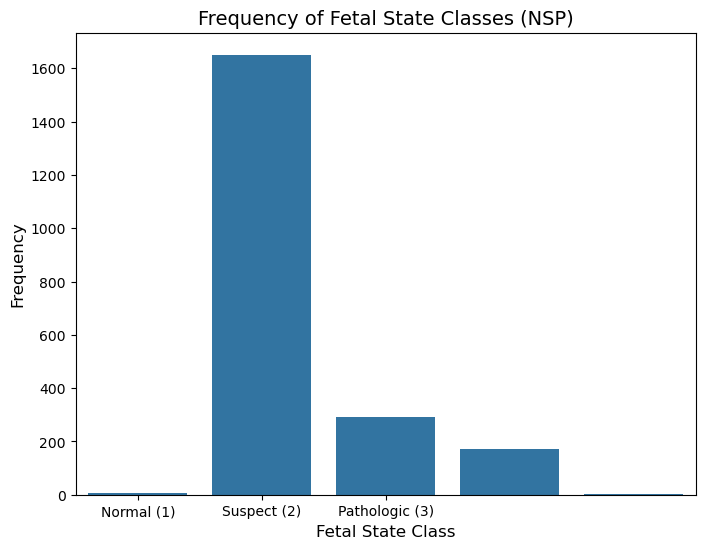

In [40]:
# 2. Bar chart for a categorical variable
plt.figure(figsize=(8, 6))
sns.countplot(x=df['NSP'])
plt.title('Frequency of Fetal State Classes (NSP)', fontsize=14)
plt.xlabel('Fetal State Class', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['Normal (1)', 'Suspect (2)', 'Pathologic (3)'])

In [48]:
#The bar chart displays the frequency of the three Fetal State Classes (NSP):
#The majority of the observations fall into the Normal (1) category, Suspect (2) and Pathologic (3), indicating that most of the monitored fetuses are classified as Normal.

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Variables')

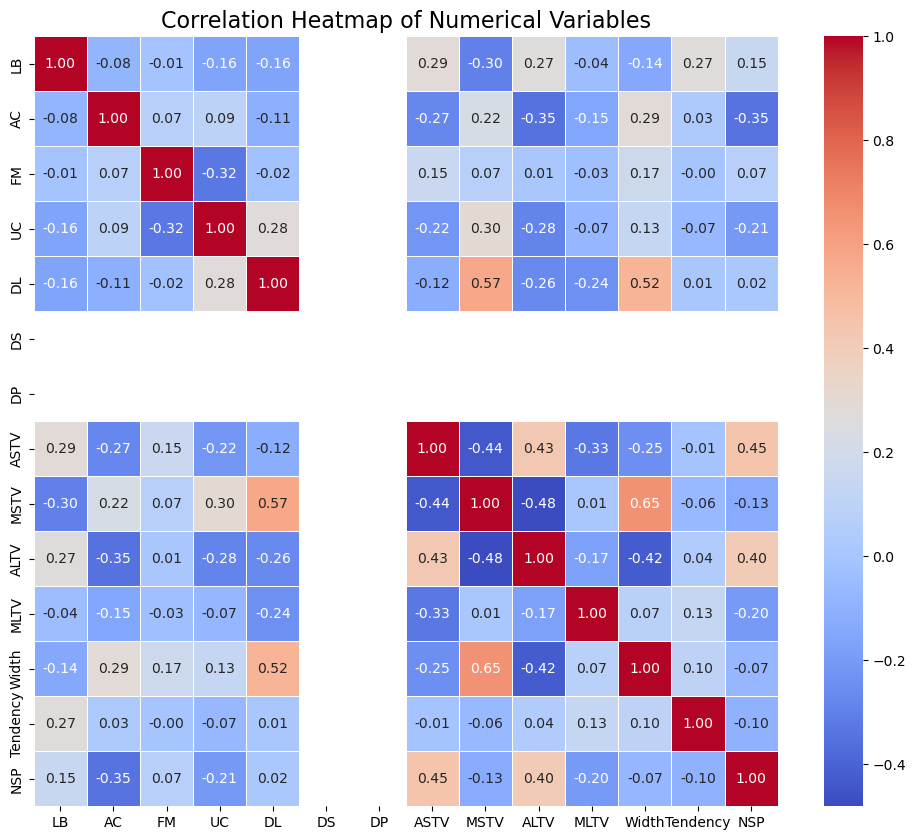

In [50]:
# 3. Correlation Heatmap
numerical_df = df.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Variables', fontsize=16)

In [46]:
#correlation implications
#The correlation heatmap shows the relationships between the numerical variables. Here are some of the most notable findings:

#AC and LB: There is a slight positive correlation, which makes sense as an increased baseline heart rate might be accompanied by more frequent accelerations.

#MSTV and MLTV: These two variables are positively correlated, suggesting that when a fetus has a higher short-term heart rate variability, they also tend to have a higher long-term variability. This is an expected pattern in healthy fetal heart rate readings.

#Contractions and Decelerations: There are strong correlations between various types of decelerations and uterine contractions. For eg, UC, DL, and DP all show positive correlations with each other. This is a crucial clinical finding, as it suggests that uterine contractions are a primary driver of decelerations, which can be an indicator of fetal distress.

([<matplotlib.axis.XTick at 0x2147665bc80>,
 [Text(0, 0, 'Normal (1)'),
  Text(1, 0, 'Suspect (2)'),
  Text(2, 0, 'Pathologic (3)')])

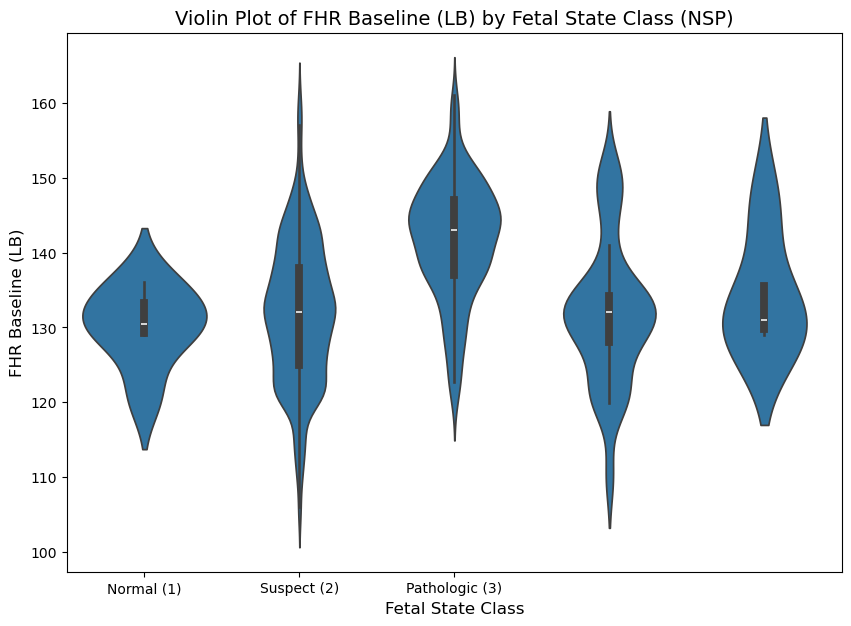

In [44]:
# 4. Violin plot
plt.figure(figsize=(10, 7))
sns.violinplot(x='NSP', y='LB', data=df)
plt.title('Violin Plot of FHR Baseline (LB) by Fetal State Class (NSP)', fontsize=14)
plt.xlabel('Fetal State Class', fontsize=12)
plt.ylabel('FHR Baseline (LB)', fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=['Normal (1)', 'Suspect (2)', 'Pathologic (3)'])

In [ ]:
#Implications and Insights
#The violin plot reveals a significant and clinically relevant pattern. The most notable insight is the difference in the distribution of heart rate baselines for the Pathologic class compared to the other two.

#For the Normal (1) and Suspect (2) classes, the violin shapes are broad and the medians are clustered around 130. This indicates that a healthy FHR baseline typically falls within a range of 120−150 beats per minute.

#However, the violin for the Pathologic (3) class is distinctly different. Its median is noticeably lower, and the entire distribution is shifted down to a lower range of heart rate values. This is a critical finding because it directly implies that a lower Fetal Heart Rate Baseline is strongly associated with a high-risk, or pathological, fetal state.

#This visualization provides a clear, data-driven insight that could be used in a clinical setting to help doctors identify fetuses that may be in distress, simply by monitoring their baseline heart rate.

In [ ]:
#While the dataset does not contain a time-series component to analyze trends over time, the visualizations revealed important relationships between variables and the Fetal State Class (NSP).
#Fetal Heart Rate Baseline (LB) and Fetal State Class (NSP): The violin plot clearly shows a significant relationship. Fetuses classified as Pathologic (NSP=3) have a noticeably lower median FHR baseline compared to those in the Normal (NSP=1) or Suspect (NSP=2) categories. This suggests that a lower fetal heart rate baseline is a potential indicator of a pathological state.
#Variability and Fetal State Class (NSP): The distributions of variability measures like Mean Short-Term Variability (MSTV) and Mean Long-Term Variability (MLTV) are highly skewed. This indicates that a lack of variability is a common characteristic in the dataset. A low variability, especially in conjunction with other factors, can be a warning sign of fetal distress.
